# 剽窃文本数据

在此项目中，你需要构建一个剽窃检测器，它会检测文本文件并进行二元分类：根据文本文件与提供的原文之间的相似度，将文件标为剽窃文件或非剽窃文件。 

使用任何数据集的第一步都是加载数据，并观察数据集包含的信息。这是最终使用这些数据的重要一步，可以了解在转换和分组数据时，你将使用什么样的特征。

这个 notebook 的主要目的就是探索数据并了解数据中的特征规律，以及数据分布情况。 

> 这个 notebook 没有任何练习或问题，只是教你探索数据。最终提交项目时，不需要包含此 notebook。

---

## 读取数据

下面的单元格将下载必要的数据并将文件解压到文件夹 `data/` 中。

此数据是谢菲尔德大学 Paul Clough（信息研究）和 Mark Stevenson（计算机科学）创建的数据集的稍加修改版本。要了解数据收集和语料库信息，请访问[谢菲尔德大学网站](https://ir.shef.ac.uk/cloughie/resources/plagiarism_corpus.html)。 

> **数据引用**：Clough, P. and Stevenson, M. Developing A Corpus of Plagiarised Short Answers, Language Resources and Evaluation:Special Issue on Plagiarism and Authorship Analysis, In Press.[下载]

In [1]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
!unzip data

--2020-05-10 23:18:40--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113826 (111K) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>] 111.16K  --.-KB/s    in 0.02s   

2020-05-10 23:18:40 (4.67 MB/s) - ‘data.zip.3’ saved [113826/113826]

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
# import libraries
import pandas as pd
import numpy as np
import os

这个剽窃数据集由多个文本文件组成；每个文件的特性都在名为 `file_information.csv` 的 `.csv` 文件中进行了总结，我们可以使用 `pandas` 读取该文件。

In [8]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

# print out the first few rows of data info
plagiarism_df.head(10)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
5,g0pB_taska.txt,a,non
6,g0pB_taskb.txt,b,non
7,g0pB_taskc.txt,c,cut
8,g0pB_taskd.txt,d,light
9,g0pB_taske.txt,e,heavy


## 剽窃类型

每个文本文件都有一个相关**任务**（任务 A-E）和一个剽窃**类别**，从上述 DataFrame 中可以看到。

###  A-E 五种任务

每个文本文件都包含一个简短问题的答案；这些问题标为任务 A-E。
* A-E 的每个任务都围绕一个主题，这些主题可能会添加到此数据集的作者制作的《计算机科学》课程表中。 
    * 例如任务 A 的问题是：“面向对象编程中的继承是什么意思？”

### 四种剽窃类别 

每个文本文件都有相关的剽窃标签/类别：

1.`cut`：答案是剽窃的，直接复制了相关的维基百科原文。
2.`light`：答案是剽窃的，在维基百科原文的基础上稍微改写了一下。
3.`heavy`：答案是剽窃的，以维基百科原文为基础，但是在表达上使用了不同的字词和结构。因为没有直接复制原文，所以可能是最有挑战性的剽窃检测类型。
4.`non`：答案没有剽窃；在提供答案时没有使用维基百科原文。
5.`orig`：这是原始维基百科文本对应的一种类别。这些文件仅作为比较基准。

> 在提交的文件中，只有 `non` 类别没有任何剽窃行为。

在下个单元格中输出关于数据的一些统计信息。

In [9]:
# print out some stats about the data
print('Number of files: ', plagiarism_df.shape[0])  # .shape[0] gives the rows 
# .unique() gives unique items in a specified column
print('Number of unique tasks/question types (A-E): ', (len(plagiarism_df['Task'].unique())))
print('Unique plagiarism categories: ', (plagiarism_df['Category'].unique()))

Number of files:  100
Number of unique tasks/question types (A-E):  5
Unique plagiarism categories:  ['non' 'cut' 'light' 'heavy' 'orig']


你应该看到数据集中文本文件的数量，以及关于 `Task` 和 `Category` 列的一些特性。**注意 100 个文件包括任务 A-E 的 5 个原始维基百科文件。**查看 `data` 目录下的文件会发现，原始文件的文件名以 `orig_` 开头，而“group”以 `g` 开头。 

> 所以共有 100 个文件，其中 95 个是答案（由用户提交的文件），5 个是原始维基百科原文。

你的最终目标是利用这一信息将任何给定的答案文本分类成以下两种类别之一：剽窃或非剽窃。

### 数据分布

接下来，我们将查看数据分布。在这门课程中，我们讨论了类别不平衡性等特性，这些特性可以告诉我们如何开发算法。所以我们将回答以下问题：**数据在不同的任务和剽窃级别间分布情况如何？**

你应该注意到两项：
* 我们的数据集很小，尤其是相对于不同剽窃级别的样本数来说。
* 数据在不同任务和剽窃类型间的分布比较均匀。

In [10]:
# Show counts by different tasks and amounts of plagiarism

# group and count by task
counts_per_task=plagiarism_df.groupby(['Task']).size().reset_index(name="Counts")
print("\nTask:")
display(counts_per_task)

# group by plagiarism level
counts_per_category=plagiarism_df.groupby(['Category']).size().reset_index(name="Counts")
print("\nPlagiarism Levels:")
display(counts_per_category)

# group by task AND plagiarism level
counts_task_and_plagiarism=plagiarism_df.groupby(['Task', 'Category']).size().reset_index(name="Counts")
print("\nTask & Plagiarism Level Combos :")
display(counts_task_and_plagiarism)


Task:


,Task,Counts
0,a,20
1,b,20
2,c,20
3,d,20
4,e,20



Plagiarism Levels:


,Category,Counts
0,cut,19
1,heavy,19
2,light,19
3,non,38
4,orig,5



Task & Plagiarism Level Combos :


,Task,Category,Counts
0,a,cut,4
1,a,heavy,3
2,a,light,3
3,a,non,9
4,a,orig,1
5,b,cut,3
6,b,heavy,4
7,b,light,3
8,b,non,9
9,b,orig,1


还可以查看最后的 DataFrame 的图形效果。

在下面可以看出计数按任务分割并呈现出一定的规律。每个任务都有一个原文（原始文件），并且 `non` 剽窃类型的数量最高。

<BarContainer object of 25 artists>

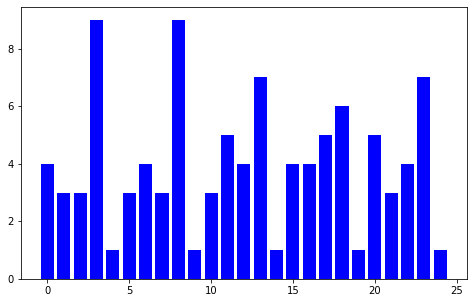

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# counts
group = ['Task', 'Category']
counts = plagiarism_df.groupby(group).size().reset_index(name="Counts")

plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')

## 后续学习计划

此 notebook 的主要目的是数据加载和探索，在最终提交项目时，不需要包含此 notebook。 

在最终项目的 notebook 中，你将使用这些数据训练一个完整的剽窃分类器。你需要从文本数据中提取有意义的特征，读取不同任务的答案，并将它们与原始维基百科文本进行比较。你需要对帮助你识别剽窃行为的相似性特征进行特征工程。然后你将在 SageMaker notebook 实例中使用这些特征训练和部署一个分类模型。 